## Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.
/Users/samyakjain/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/samyakjain/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/samyakjain/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

In [2]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions
    

In [14]:
import os

In [113]:
len(os.listdir("flickr30k_images/flickr30k_images"))

31785

In [12]:
import csv
captions  = pd.read_csv("results.csv", escapechar = "\\",quoting = csv.QUOTE_NONE, error_bad_lines=False)
captions.head()

b'Skipping line 3: expected 1 fields, saw 2\nSkipping line 22: expected 1 fields, saw 4\nSkipping line 39: expected 1 fields, saw 2\nSkipping line 48: expected 1 fields, saw 2\nSkipping line 68: expected 1 fields, saw 2\nSkipping line 92: expected 1 fields, saw 4\nSkipping line 93: expected 1 fields, saw 3\nSkipping line 94: expected 1 fields, saw 2\nSkipping line 97: expected 1 fields, saw 3\nSkipping line 99: expected 1 fields, saw 2\nSkipping line 101: expected 1 fields, saw 2\nSkipping line 117: expected 1 fields, saw 2\nSkipping line 133: expected 1 fields, saw 2\nSkipping line 187: expected 1 fields, saw 3\nSkipping line 202: expected 1 fields, saw 3\nSkipping line 208: expected 1 fields, saw 2\nSkipping line 222: expected 1 fields, saw 2\nSkipping line 238: expected 1 fields, saw 2\nSkipping line 241: expected 1 fields, saw 2\nSkipping line 247: expected 1 fields, saw 3\nSkipping line 252: expected 1 fields, saw 2\nSkipping line 278: expected 1 fields, saw 3\nSkipping line 292: 

image_name| comment_number| comment
0  1000092795.jpg| 0| Two young guys with shaggy ...
1  1000092795.jpg| 2| Two men in green shirts are...
2  1000092795.jpg| 3| A man in a blue shirt stand...
3  1000092795.jpg| 4| Two friends enjoy time spen...
4  10002456.jpg| 0| Several men in hard hats are ...

In [21]:
captions["image_name| comment_number| comment"][0].split("| ")

['1000092795.jpg',
 '0',
 'Two young guys with shaggy hair look at their hands while hanging out in the yard .']

In [9]:
a = []
b = []
c = []
for i in range(len(5)):
    
    a.append(captions["image_name| comment_number| comment"][i].split("| ")[0])
    b.append(captions["image_name| comment_number| comment"][i].split("| ")[1])
    c.append(captions["image_name| comment_number| comment"][i].split("| ")[2])

image_name| comment_number| comment
0       1000092795.jpg| 0| Two young guys with shaggy ...
1       1000092795.jpg| 2| Two men in green shirts are...
2       1000092795.jpg| 3| A man in a blue shirt stand...
3       1000092795.jpg| 4| Two friends enjoy time spen...
4       10002456.jpg| 0| Several men in hard hats are ...
...                                                   ...
141846  99804383.jpg| 2| A older Asian man is playing ...
141847  99804383.jpg| 3| An elderly man sits outside a...
141848  99804383.jpg| 4| An elderly gentleman playing ...
141849  998845445.jpg| 2| A man is leaning off of the ...
141850  998845445.jpg| 4| A man on a moored blue and w...

[141851 rows x 1 columns]

In [8]:
print(len(captions))

141851


In [33]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [25]:
# Dictionary to Map each Image with the list of captions it has

In [22]:
caption = captions[:5]
caption

image_name| comment_number| comment
0  1000092795.jpg| 0| Two young guys with shaggy ...
1  1000092795.jpg| 2| Two men in green shirts are...
2  1000092795.jpg| 3| A man in a blue shirt stand...
3  1000092795.jpg| 4| Two friends enjoy time spen...
4  10002456.jpg| 0| Several men in hard hats are ...

In [42]:
captions["image_name| comment_number| comment"][18004].split("| ")[1].split("   ")[1]

'A dog runs across the grass .'

In [43]:
descriptions = {}

for x in range(len(captions)):
    try:
        first,third,second = captions["image_name| comment_number| comment"][x].split("| ")
        img_name = first.split(".")[0]
        
        #if the image id is already present or not
        if descriptions.get(img_name) is None:
            descriptions[img_name] = []

        descriptions[img_name].append(second)
    except:
        first,second = captions["image_name| comment_number| comment"][x].split("| ")
        img_name = first.split(".")[0]
        second = second.split("   ")[1]
        #if the image id is already present or not
        if descriptions.get(img_name) is None:
            descriptions[img_name] = []
        descriptions[img_name].append(second)

In [45]:
descriptions['104136873']

['Three people are on a hilltop overlooking a green valley .',
 'People sit on the mountainside and check out the view .',
 'Three people rest on a ledge above the moutains .',
 'Three people hang out on top of a big hill .',
 'Three people overlook a green valley .']

In [49]:
l = []
for i in os.listdir("flickr30k_images/flickr30k_images"):
    l.append(i)
len(l)

31785

In [51]:
if "104136873.jpg" in l:
    print(True)

True


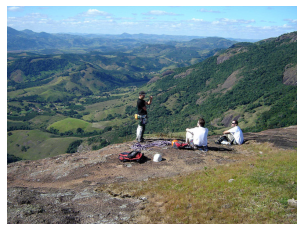

In [53]:
IMG_PATH = "flickr30k_images/flickr30k_images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"104136873.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
# print(img.shape)


### Data Cleaning


In [54]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [55]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [56]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [57]:
descriptions["104136873"]

['three people are on hilltop overlooking green valley',
 'people sit on the mountainside and check out the view',
 'three people rest on ledge above the moutains',
 'three people hang out on top of big hill',
 'three people overlook green valley']

In [58]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [59]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [60]:
print(type(descriptions))

<class 'dict'>


In [61]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 16862


In [62]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))


Total Words 1412215


In [63]:
# Filter Words from the Vocab according to certain threshold frequncy

In [64]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

16862


In [65]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [66]:
print(len(total_words))

4657


### Prepare Train/Test Data

In [90]:
df1 = pd.DataFrame.from_dict(descriptions,orient="index")

In [91]:
df1.columns = ["caption1","caption2","caption3","caption4","caption5"]

In [92]:
df1['image_name'] = df1.index
df1 = df1.reset_index(drop=True)
df1

caption1  \
0      two young guys with shaggy hair look at their ...   
1      several men in hard hats are operating giant p...   
2      child in pink dress is climbing up set of stai...   
3      someone in blue shirt and hat is standing on s...   
4      two guy cooking and joking around with the camera   
...                                                  ...   
31775          woman standing near decorated wall writes   
31776  person in red shirt climbing up rock face cove...   
31777  two male construction workers are working on s...   
31778  an older busker in glasses plays an eastern st...   
31779  man is leaning off of the side of blue and whi...   

                                                caption2  \
0           two men in green shirts are standing in yard   
1      workers look down from up above on piece of eq...   
2      little girl in pink dress going into wooden cabin   
3      man in blue shirt is standing on ladder cleani...   
4               two men in kitchen cooking food on stove   
...                                                  ...   
31775         the walls are covered in gold and patterns   
31776       rock climber practices on rock climbing wall   
31777  two workmen with wheelbarrow for mixing cement...   
31778  this is man in front of store performing with ...   
31779  man on moored blue and white boat with hills a...   

                                                caption3  \
0                   man in blue shirt standing in garden   
1           two men working on machine wearing hard hats   
2       little girl climbing the stairs to her playhouse   
3       man on ladder cleans the window of tall building   
4                two men are at the stove preparing food   
...                                                  ...   
31775              woman behind scrolled wall is writing   
31776                 man in pink shirt climbs rock face   
31777  men in orange and yellow clothing lean over st...   
31778  older asian man is playing an instrument in fr...   
31779                                               None   

                                                caption4  \
0                  two friends enjoy time spent together   
1                      four men on top of tall structure   
2             little girl climbing into wooden playhouse   
3      man in blue shirt and jeans on ladder cleaning...   
4                               two men are cooking meal   
...                                                  ...   
31775                    person stands near golden walls   
31776               man is rock climbing high in the air   
31777  men are working on pouring concrete outside of...   
31778  an elderly man sits outside storefront accompa...   
31779                                               None   

                                                caption5  image_name  
0                                                   None  1000092795  
1                                 three men on large rig    10002456  
2                        girl going into wooden building  1000268201  
3                            man on ladder cleans window  1000344755  
4                                                   None  1000366164  
...                                                  ...         ...  
31775                                               None   997338199  
31776                          rock climber in red shirt   997722733  
31777               fruits stationed by dusty old window   997876722  
31778  an elderly gentleman playing musical instrumen...    99804383  
31779                                               None   998845445  

[31780 rows x 6 columns]

In [93]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2)

In [94]:
train

caption1  \
28326  two men in jeans and button down shirts are da...   
18720  two children are posing with jack lanterns tha...   
30511  two cyclists on bikes riding towards camera wi...   
3187   woman in white halter top and man wearing whit...   
10459  boy wearing full riding gear is riding his bik...   
...                                                  ...   
28374  one construction worker hands another some sor...   
1150   man tries to catch football on grass surrounde...   
4868   father and son are tucked tightly together whi...   
15938  person swimming in pool next to some chairs an...   
6096   painter sits on dangerous wooden ledge while p...   

                                                caption2  \
28326  two men making dance moves as woman films the ...   
18720  little boy sitting outside looking at lit up j...   
30511  two bikers with people in the background waiti...   
3187   young man in white shirt holding cotton candy ...   
10459  child wearing bicycle helmet and uniform is ri...   
...                                                  ...   
28374  workers are wearing life jacket and working at...   
1150   man is being thrown frisbee in front of monume...   
4868   man with closed eyes holding baby with closed ...   
15938     person doing the backstroke in an outdoor pool   
6096   painter is painting white window outside brick...   

                                                caption3  \
28326  two men are practicing dance routine while the...   
18720  boy with blond hair sits behind two jack lanterns   
30511  two bicyclist riding their bikes outside on track   
3187   woman in white with her arms folded smiling as...   
10459        young man in bicycle helmet rides on street   
...                                                  ...   
28374      several workers standing on and around ladder   
1150   man is clapping at the base of the washington ...   
4868         man cuddling with child on an orange pillow   
15938       the person is swimming on their back in pool   
6096            man working on building three stories up   

                                                caption4  \
28326  two men are practicing dance moves while lady ...   
18720     two children sitting with lit up jack lanterns   
30511       team great britain cycles to the finish line   
3187   woman is smiling next to man who is also smili...   
10459          boy in helmet riding his bike in marathon   
...                                                  ...   
28374         two guys working together fixing something   
1150               man in field backed by american flags   
4868            father and his son cuddle while sleeping   
15938                  swimmer doing backstrokes in pool   
6096             sign on store in and urban neighborhood   

                                       caption5  image_name  
28326  two man dancing while posing for picture  6208991202  
18720     two children light their jack laterns  4184328304  
30511                                      None  7650753866  
3187    people laughing and eating cotton candy   207015505  
10459            cyclist riding bicycle on road  3016178284  
...                                         ...         ...  
28374                                      None  6229823951  
1150    man stands in front of the gateway arch   135235570  
4868    father and son asleep in their blankets  2313598755  
15938           person doing backstroke in pool  3636491114  
6096                  man sitting on windowsill  2461641557  

[25424 rows x 6 columns]

In [67]:
# train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
# test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")


FileNotFoundError: [Errno 2] No such file or directory: 'Data/Flickr_TextData/Flickr_8k.trainImages.txt'

In [99]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [103]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [105]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [106]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [95]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [96]:
model_new = Model(model.input,model.layers[-2].output)

In [97]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [98]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [99]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [100]:
encode_image(IMG_PATH+"6208991202.jpg")

array([0.16405454, 1.5707098 , 0.19307435, ..., 4.1775746 , 0.987614  ,
       1.0209392 ], dtype=float32)

In [107]:
for ix,img_id in enumerate(train["image_name"]):

    print(ix,img_id)
    break

0 6208991202


In [108]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train["image_name"]):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

Encoding in Progress Time step 21900 
Encoding in Progress Time step 22000 
Encoding in Progress Time step 22100 
Encoding in Progress Time step 22200 
Encoding in Progress Time step 22300 
Encoding in Progress Time step 22400 
Encoding in Progress Time step 22500 
Encoding in Progress Time step 22600 
Encoding in Progress Time step 22700 
Encoding in Progress Time step 22800 
Encoding in Progress Time step 22900 
Encoding in Progress Time step 23000 
Encoding in Progress Time step 23100 
Encoding in Progress Time step 23200 
Encoding in Progress Time step 23300 
Encoding in Progress Time step 23400 
Encoding in Progress Time step 23500 
Encoding in Progress Time step 23600 
Encoding in Progress Time step 23700 
Encoding in Progress Time step 23800 
Encoding in Progress Time step 23900 
Encoding in Progress Time step 24000 
Encoding in Progress Time step 24100 
Encoding in Progress Time step 24200 
Encoding in Progress Time step 24300 
Encoding in Progress Time step 24400 
Encoding in 

In [109]:
!mkdir saved

In [110]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [263]:
(encoding_train["6208991202"].shape)

(2048,)

In [112]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test["image_name"]):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Test Encoding in Progress Time step 1000 
Test Encoding in Progress Time step 1100 
Test Encoding in Progress Time step 1200 
Test Encoding in Progress Time step 1300 
Test Encoding in Progress Time step 1400 
Test Encoding in Progress Time step 1500 
Test Encoding in Progress Time step 1600 
Test Encoding in Progress Time step 1700 
Test Encoding in Progress Time step 1800 
Test Encoding in Progress Time step 1900 
Test Encoding in Progress Time step 2000 
Test Encoding in Progress Time step 2100 
Test Encoding in Progress Time step 2200 
Test Encoding in Progress Time step 2300 
Test

In [114]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### Data pre-processing for Captions

In [115]:
# Vocab
len(total_words)

4657

In [116]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [117]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

4657


In [118]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 4660


In [129]:
train_descriptions = train.copy()

In [130]:
train_descriptions = train_descriptions.set_index('image_name').T.to_dict('list')
train_descriptions

{'6208991202': ['two men in jeans and button down shirts are dancing while woman in black pants and gray shirt takes their picture',
  'two men making dance moves as woman films the event in the living room of house or apartment',
  'two men are practicing dance routine while their friend captures it on camera',
  'two men are practicing dance moves while lady takes photo',
  'two man dancing while posing for picture'],
 '4184328304': ['two children are posing with jack lanterns that are lit up from the inside',
  'little boy sitting outside looking at lit up jack lanterns',
  'boy with blond hair sits behind two jack lanterns',
  'two children sitting with lit up jack lanterns',
  'two children light their jack laterns'],
 '7650753866': ['two cyclists on bikes riding towards camera with group of people behind them facing the other way in line for something',
  'two bikers with people in the background waiting in line',
  'two bicyclist riding their bikes outside on track',
  'team gre

In [185]:
for key in train_descriptions.keys():
    res = []
    for cap in train_descriptions[key]:
        if cap != None :
            res.append(cap)
    train_descriptions[key] = res

In [186]:
train_descriptions["7650753866"]

['two cyclists on bikes riding towards camera with group of people behind them facing the other way in line for something',
 'two bikers with people in the background waiting in line',
 'two bicyclist riding their bikes outside on track',
 'team great britain cycles to the finish line']

In [303]:
max_len = 0
for key in train_descriptions.keys():
    res = []
    max_len2 = 0
    for cap in train_descriptions[key]:
        max_len2 = max(max_len,len(cap.split()))
        if max_len2 < 22:
            res.append(cap)
        max_len2 = 0
    train_descriptions[key] = res

In [304]:
max_len = 0 
for key in train_descriptions.keys():
#     try:
        for cap in train_descriptions[key]:
            max_len = max(max_len,len(cap.split()))
#     except:
#         pass
        
print(max_len)

21


In [310]:
max_len1 = 0
lenght = []
for key in train_descriptions.keys():
#     try:
        max_len2 = 0
        for cap in train_descriptions[key]:
            max_len2 = max(max_len1,len(cap.split()))
#             if max_len1 > 67:
#                 print(key+" "+cap)
            lenght.append(max_len2)
            max_len2 = 0
#     except:
#         pass
        
print(max_len1)

0


In [311]:
max(lenght)

21

In [312]:
lenght1 = pd.DataFrame(lenght,columns=["lenght"])
lenght1.head()

lenght
0      21
1      18
2      13
3      10
4       7

In [313]:
lenght_count = dict(lenght1["lenght"].value_counts())
lenght_count = pd.DataFrame.from_dict(lenght_count,orient="index")
lenght_count.columns = ["count"]
lenght_count['lenght'] = lenght_count.index
lenght_count = lenght_count.reset_index(drop=True)
lenght_count

count  lenght
0   13846       8
1   12929       9
2   12794       7
3   11628      10
4   10313       6
5    9686      11
6    7963      12
7    6697       5
8    6198      13
9    4722      14
10   3511      15
11   2723       4
12   2567      16
13   1962      17
14   1414      18
15   1076      19
16    758      20
17    573      21
18    509       3
19     85       2
20      4       1

<AxesSubplot:xlabel='lenght'>

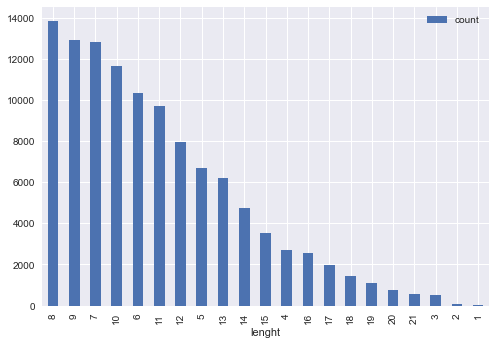

In [314]:
lenght_count.plot(x="lenght",y=["count"],kind="bar")

/Users/samyakjain/opt/anaconda3/envs/IntroToTensorFlow/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


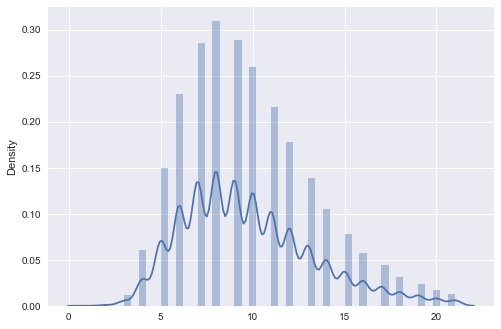

In [315]:
import seaborn as sns
ax = sns.distplot(lenght)

In [317]:
max_len = 21

In [344]:
keras.applications.__version__

AttributeError: module 'keras.applications' has no attribute '__version__'

In [318]:
cap1 = "in this photo there is man in dirty white shirt red and black hat with yellow stained teeth there is also someone standing next to him but only there arm and plaid white sleeve is showing the looks happy and it appears that he is also repairing something he has his tools laying around him although it is unclear what he is fixing he looks happy doing it"

In [319]:
len(cap1.split()),cap1.split()

(68,
 ['in',
  'this',
  'photo',
  'there',
  'is',
  'man',
  'in',
  'dirty',
  'white',
  'shirt',
  'red',
  'and',
  'black',
  'hat',
  'with',
  'yellow',
  'stained',
  'teeth',
  'there',
  'is',
  'also',
  'someone',
  'standing',
  'next',
  'to',
  'him',
  'but',
  'only',
  'there',
  'arm',
  'and',
  'plaid',
  'white',
  'sleeve',
  'is',
  'showing',
  'the',
  'looks',
  'happy',
  'and',
  'it',
  'appears',
  'that',
  'he',
  'is',
  'also',
  'repairing',
  'something',
  'he',
  'has',
  'his',
  'tools',
  'laying',
  'around',
  'him',
  'although',
  'it',
  'is',
  'unclear',
  'what',
  'he',
  'is',
  'fixing',
  'he',
  'looks',
  'happy',
  'doing',
  'it'])

### Data Loader (Generator)

In [320]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [321]:
s = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
s

<generator object data_generator at 0x7fece75a4ed0>

## Word Embeddings 

In [322]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [323]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [324]:
f.close()

In [325]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [326]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [327]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(4660, 50)

In [328]:
#embedding_matrix[1847]

#### Model Architecture

In [329]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [330]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [331]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [332]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 21)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 21, 50)       233000      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [333]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [334]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [335]:
(train_descriptions)

{'6208991202': ['two men in jeans and button down shirts are dancing while woman in black pants and gray shirt takes their picture',
  'two men making dance moves as woman films the event in the living room of house or apartment',
  'two men are practicing dance routine while their friend captures it on camera',
  'two men are practicing dance moves while lady takes photo',
  'two man dancing while posing for picture'],
 '4184328304': ['two children are posing with jack lanterns that are lit up from the inside',
  'little boy sitting outside looking at lit up jack lanterns',
  'boy with blond hair sits behind two jack lanterns',
  'two children sitting with lit up jack lanterns',
  'two children light their jack laterns'],
 '7650753866': ['two cyclists on bikes riding towards camera with group of people behind them facing the other way in line for something',
  'two bikers with people in the background waiting in line',
  'two bicyclist riding their bikes outside on track',
  'team gre

### Training of Model

In [336]:
epochs = 20
batch_size = 3
number_pics_per_batch = 200
steps = len(train_descriptions)//number_pics_per_batch


In [337]:
def train():
    
    for i in range(epochs):
        try:
            generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
#             print(generator)
            model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
#             print("1")
            model.save('./model_weights_without_maxlen/model_'+str(i)+'.h5')
        except Exception as e:
            print(e)
    

In [338]:
from keras.utils import to_categorical
train()

Epoch 1/1
127/127 [==============================] - 12s 93ms/step - loss: 6.5252
Epoch 1/1
127/127 [==============================] - 12s 91ms/step - loss: 5.6173
Epoch 1/1
127/127 [==============================] - 11s 87ms/step - loss: 5.2110
Epoch 1/1
127/127 [==============================] - 11s 89ms/step - loss: 4.8765
Epoch 1/1
127/127 [==============================] - 11s 88ms/step - loss: 4.5245
Epoch 1/1
127/127 [==============================] - 11s 88ms/step - loss: 4.2059
Epoch 1/1
127/127 [==============================] - 11s 90ms/step - loss: 3.9521
Epoch 1/1
127/127 [==============================] - 11s 90ms/step - loss: 3.7338
Epoch 1/1
127/127 [==============================] - 11s 90ms/step - loss: 3.5868
Epoch 1/1
127/127 [==============================] - 12s 94ms/step - loss: 3.3771
Epoch 1/1
127/127 [==============================] - 12s 92ms/step - loss: 3.2433
Epoch 1/1
127/127 [==============================] - 12s 92ms/step - loss: 3.0879
Epoch 1/1
127/12

In [339]:
model = load_model('model_weights_without_maxlen/model_19.h5')

## Predictions

In [340]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

4789503952


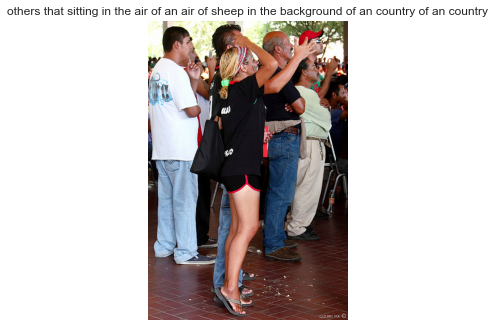

In [341]:
plt.style.use("seaborn")
# for i in range(15):
idx = np.random.randint(0,1000)
all_img_names = list(encoding_train.keys())
img_name = all_img_names[idx]
photo_2048 = encoding_train[img_name].reshape((1,2048))

i = plt.imread("flickr30k_images/flickr30k_images/"+img_name+".jpg")
print(img_name)
caption = predict_caption(photo_2048)
#print(caption)
caption = clean_text(caption)
plt.title(caption)
plt.imshow(i)
plt.axis("off")
plt.show()

3283913180


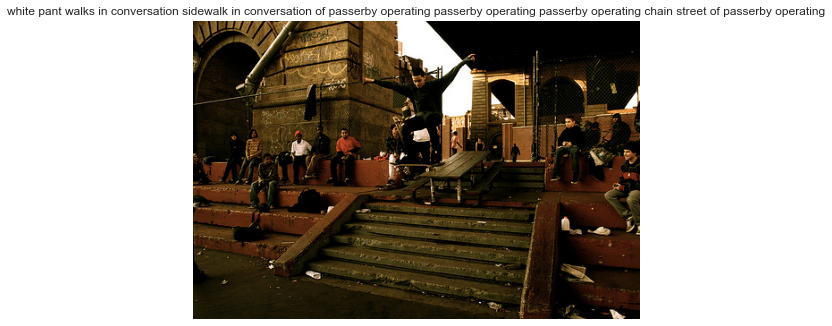

294839797


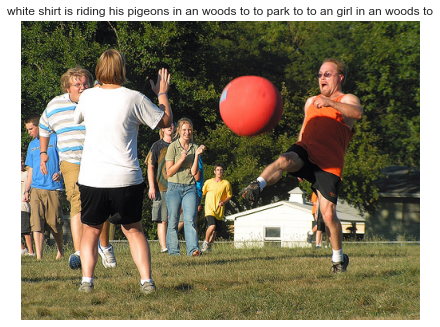

363701711


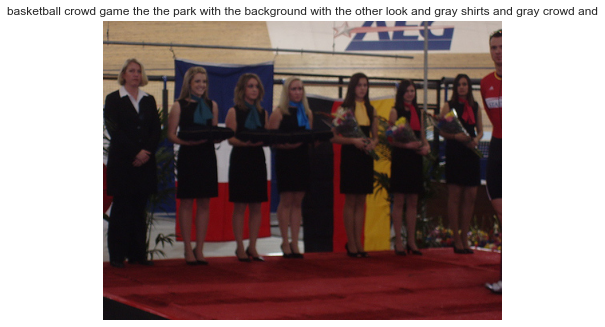

4274035185


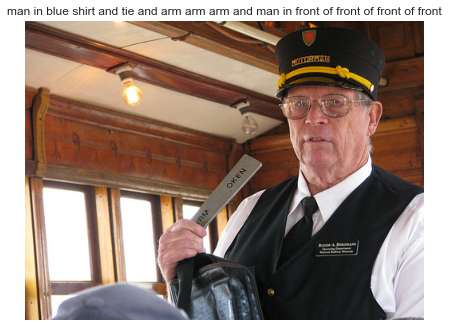

1457762320


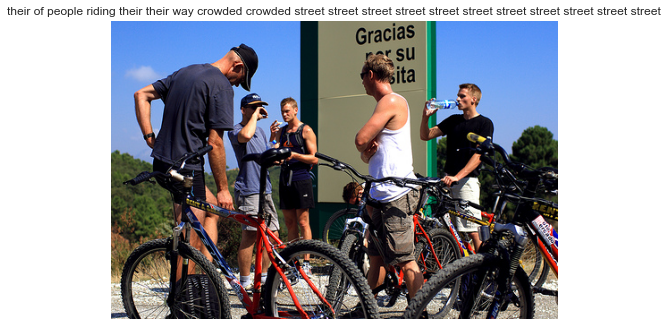

3188036349


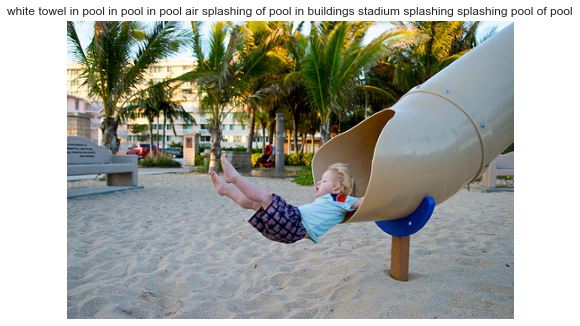

3048904615


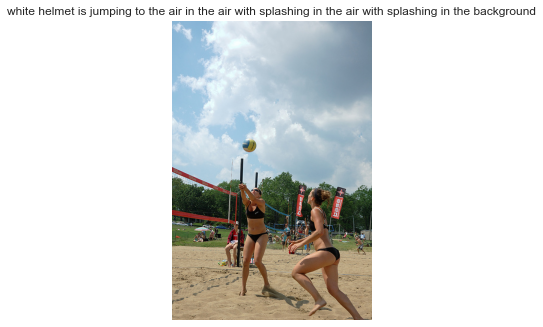

6234683720


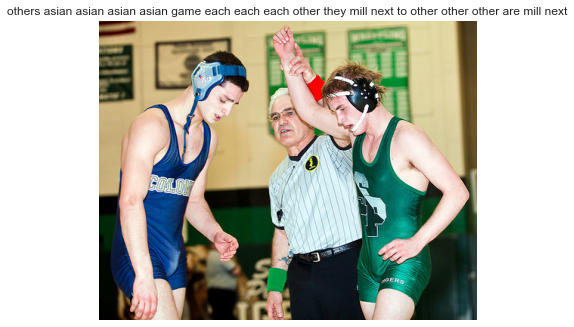

4557307607


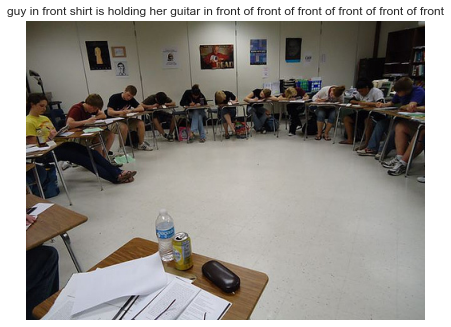

4817877393


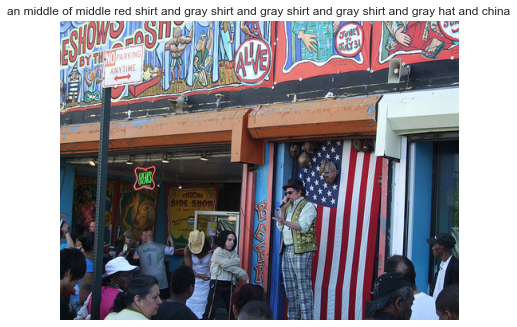

4848511967


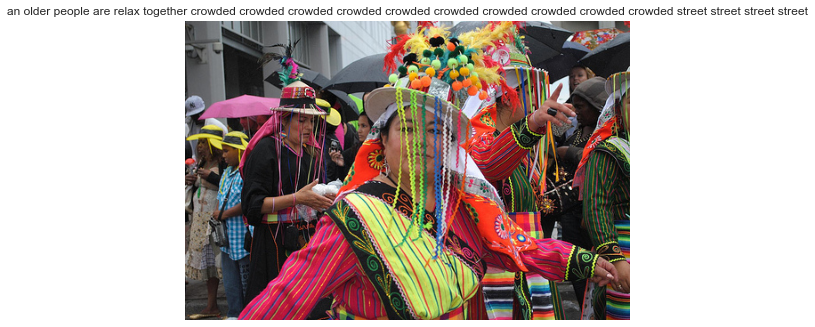

18119750


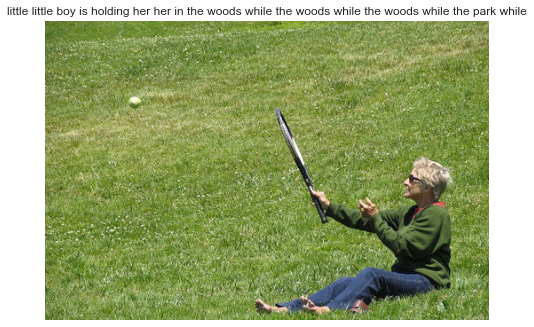

3415228562


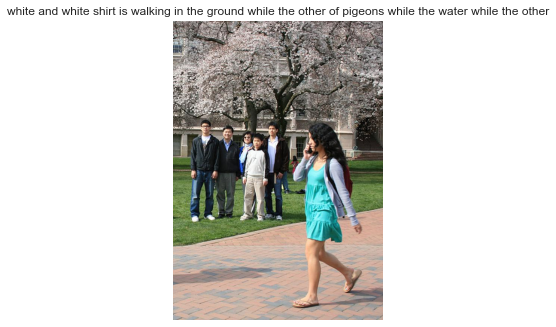

3599780784


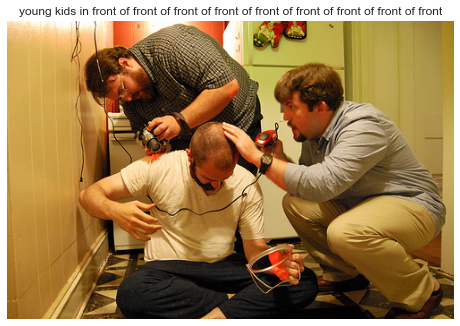

2423886164


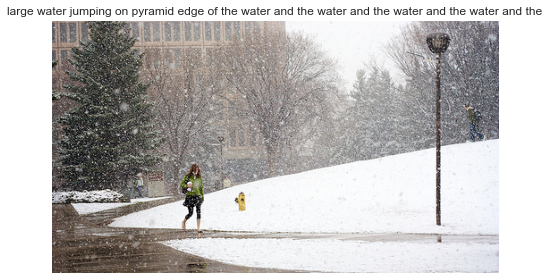

In [342]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("flickr30k_images/flickr30k_images/"+img_name+".jpg")
    print(img_name)
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [218]:
#encoding_test["3385593926_d3e9c21170"].shape